In [1]:
import random_termination
import graph_utilities
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sf = graph_utilities.sf_map()
central_sf = nx.subgraph(sf, nx.strongly_connected_components(sf)[0])

In [3]:
central_sf_caller_locations = list(np.random.choice(central_sf, size=(10,)))
central_sf_caller_probabilities = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [4]:
not_caller = filter(lambda a: a not in central_sf_caller_locations, central_sf.nodes())

In [5]:
sf_cost_exceeding = graph_utilities.graph_cost(
    central_sf, 
    central_sf_caller_locations, 
    central_sf_caller_probabilities, 
    graph_utilities.make_exceeding_distance_cost(350))

In [6]:
sf_cost_expectation = graph_utilities.graph_cost(
    central_sf, 
    central_sf_caller_locations, 
    central_sf_caller_probabilities, 
    graph_utilities.expected_value)

In [7]:
sf_exceeding_cost, sf_exceeding_edgelist = random_termination.random_termination_single_cost_edgelist(central_sf, sf_cost_exceeding, 0.06)

In [8]:
sf_expectation_cost, sf_expectation_edgelist = random_termination.random_termination_single_cost_edgelist(central_sf, sf_cost_expectation, 0.06)

In [9]:
sf_exceeding_expectation_cost, sf_exceeding_expectation_edgelist = random_termination.random_termination_double_cost_edgelist(central_sf, sf_cost_exceeding, sf_cost_expectation, 0.06)

In [14]:
def pdf_from_cost(graph, ec, el, g, p, starting_node, caller_locations, caller_probabilities):
 
    path = graph_utilities.make_path(g, starting_node)
    
    gud = graph_utilities.summed_pdf(graph,
                                     path,
                                     caller_locations,
                                     caller_probabilities,
                                     p)
    
    d_pdf, p_pdf = graph_utilities.make_pdf(gud)
    
    return d_pdf, p_pdf

In [15]:
dsg = graph_utilities.make_direction_subgraph(central_sf, sf_expectation_edgelist)
distributions_expectation_pdf = { node: pdf_from_cost(central_sf, sf_expectation_cost, sf_expectation_edgelist, dsg,
                  0.06, node, central_sf_caller_locations, central_sf_caller_probabilities)
                    for node in central_sf.nodes()}

[0, 2430, 1e-16, 1]

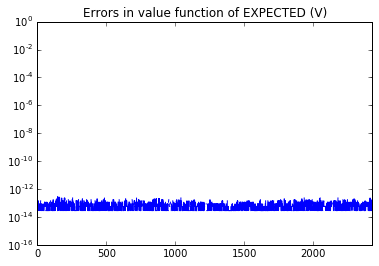

In [20]:
errors = []
for node in central_sf.nodes():
    d,p = distributions_expectation_pdf[node]
    expectation_from_distribution = np.dot(np.array(d), np.array(p))
    error = np.abs(sf_expectation_cost[node] - expectation_from_distribution)
    errors.append(error)
plt.title("Errors in value function of EXPECTED (V)")
plt.semilogy(errors)
plt.axis([0, len(errors), 1e-16, 1])

In [41]:
dsg = graph_utilities.make_direction_subgraph(central_sf, sf_exceeding_expectation_edgelist)
distribution_exceeding_expectation = { node: [pdf_from_cost(central_sf, { node: sf_exceeding_expectation_cost[node][0] for node in central_sf.nodes() }, sf_exceeding_expectation_edgelist, dsg,
                  0.06, node, central_sf_caller_locations, central_sf_caller_probabilities),
                    pdf_from_cost(central_sf, { node: sf_exceeding_expectation_cost[node][1] for node in central_sf.nodes() }, sf_exceeding_expectation_edgelist, dsg,
                  0.06, node, central_sf_caller_locations, central_sf_caller_probabilities)]
                    for node in central_sf.nodes()}

[0, 2430, 1e-16, 1]

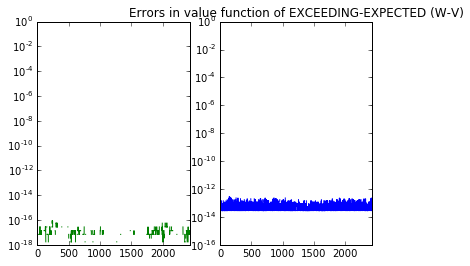

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2)
errors = []
for node in central_sf.nodes():
    (dx,px),(de,pe) = distribution_exceeding_expectation[node]
    expectation_from_distribution = np.dot(np.array(de), np.array(pe))
    p_exceeding_from_distribution = sum(px[dx > 350.0])
    error = [np.abs(p_exceeding_from_distribution - sf_exceeding_expectation_cost[node][0]),
             np.abs(sf_exceeding_expectation_cost[node][1] - expectation_from_distribution)]
    errors.append(error)
errors = np.array(errors)
plt.title("Errors in value function of EXCEEDING-EXPECTED (W-V)")
ax1.semilogy(errors[:,0], color="green")
ax2.semilogy(errors[:,1], color="blue")
ax1.axis([0, len(errors), 1e-18, 1])
ax2.axis([0, len(errors), 1e-16, 1])

In [30]:
dsg = graph_utilities.make_direction_subgraph(central_sf, sf_exceeding_expectation_edgelist)
distributions_exceeding = { node: pdf_from_cost(central_sf, sf_exceeding_cost, sf_exceeding_edgelist, dsg,
                  0.06, node, central_sf_caller_locations, central_sf_caller_probabilities)
                    for node in central_sf.nodes()}

[0, 2430, 1e-18, 1]

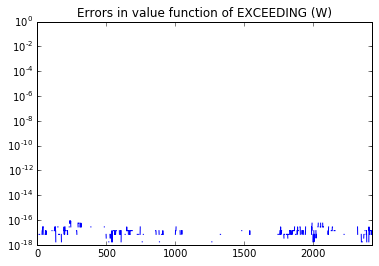

In [38]:
errors = []
for node in central_sf.nodes():
    d,p = distributions_exceeding[node]
    p_exceeding_from_distribution = sum(p[d > 350.0])
    error = np.abs(sf_exceeding_cost[node] - p_exceeding_from_distribution)
    errors.append(error)
plt.title("Errors in value function of EXCEEDING (W)")
plt.semilogy(errors)
plt.axis([0, len(errors), 1e-18, 1])